<H1 style="text-align: center">ECMM422 - Machine Learning</H1>
<H2 style="text-align: center">Assignment 4: Reinforcement Learning</H2>

| Date set     | Hand-in date |
|:------------------|:-----------------------------------|
| 6th March 2020  | **  Wednesday 18th March ** |


This workshop is worth 25% of the total module mark.



Candidate number:  <font color="red">*660031764*</font>

Your report should consist of your IPython notebook showing what you did, what was the
result, and what you can conclude from the exercise. Each report will be
assessed on the following criteria:

* Does it record what was done in the exercise?
* Does it permit the results to be reproduced?
* How does the work relate to the theoretical foundations discussed in lectures?
* Is it well presented?

### Submitting the notebooks

Note that an electronic submission is required.  You should also submit the notebook electronically at [electronic hand-in system]( http://empslocal.ex.ac.uk/submit/).  You just need to submit the single .ipynb file that is the notebook, so you should be able to upload it directly from the directory where you have saved it on a University machine or your laptop.  If you're not sure where in your homespace it is, type <code>pwd</code> (print working directory) in a cell to find out where the notebooks are.

<b>Note: you must also submit your cover sheet and E-Submit receipt via BART to complete the submission.</b>


<div class="alert alert-info">
Although you will undoubtedly work collaboratively in the workshops themselves, these are *individual* exercises.  The reports you write should be about the results *you* obtained, and your attention is drawn to the College and University guidelines on collaboration and plagiarism. 
</div>


In [1]:
# including libraries as usual
import matplotlib.pyplot as plt
import numpy as np


# Gridworld example

The following code will provide you with a working gridworld problem. You are asked to study the code and use it to provide a solution in the following questions. 


In [2]:
class GridWorld: 
    '''
    Class implementing a typical GridWorld problem. 
    
    '''
    
    
    def __init__(self, width, height, gamma=1, penalty=-1, start=[0,0], goal=[0,0], cliff=[], cliff_penalty=-10):
        '''
        Generates a new Gridworld problem, with a grid of size (width,height). 
        gamma: reward discount parameter (default:1)
        penalty: penalty for each move (default:-1)
        start: start location (default: [0,0])
        goal: goal location (default: [0,0])
        cliff: list of locations defined as cliff (the agent incurs a large penalty for walking into cliffs and is transported back to the start). 
        cliff_penalty: penalty incurred for walking into a cliff (default: -100). 
        '''
        # define the four possible actions
        self.gamma = gamma
        self.actions = range(4)
        self.delta = np.array([[0,-1],[+1,0],[0,+1],[-1,0]])
        self.actions_labels = ['up','right','down','left']
        
        self.states = range(width*height)

        self.width = width
        self.height = height
        
        # set the start state
        self.start = self.encode_state(start)     

        self.cliff = [self.encode_state(s) for s in cliff]
        self.goal = self.encode_state(goal)
        self.penalty = penalty
        self.cliff_penalty = cliff_penalty
        self.grid = np.zeros((height,width))
        for c in range(width): 
            for r in range(height): 
                if [c,r] == goal: 
                    self.grid[r,c] = 1
                elif [c,r] in cliff: 
                    self.grid[r,c] = 2
                elif [c,r] == start: 
                    self.grid[r,c] = 3
        
    def line_string(self):
        s = '+'
        for j in range(self.width):
            s += '-+'
        s += '\n'
        return s
        
    def tostring(self): 
        '''
            Converts the grid world to a formatted string. 
        '''
        s = 'Grid world:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                elif self.grid[r,c] == 3:
                    s += 'S'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s    
    
    def print_solution(self,S): 
        '''
        Graphical display of a solution S, given as a list of states that brings from the initial state to the goal. 
        '''
        s = 'Solution:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                p = self.encode_state((c,r))                
                
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 3:
                    s += 'S'
                elif p in S:
                    if p == S[-1]:
                        s += '@'
                    else:
                        s += '*'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s 
    
    def show_states(self):
        '''
        Displays state IDs on a grid. 
        '''
        print( np.array(self.states).reshape((self.width,self.height)).T )
    
    def encode_state(self,coord):
        '''
        Converts a tuple (c,r) containing grid coordinates to the corresponding (scalar) state ID. 
        '''
        (c,r) = coord
        if r<self.height and c<self.width and r>=0 and c>=0: 
            return int(c*self.height+r)
        else: 
            return -1
    
    def decode_state(self,s): 
        '''
        Converts a state ID into grid coordinates. 
        '''
        return (s//self.height,s%self.height)
        
    def state_action_state(self,s,a): 
        '''
        Generates the next state and associated reward for a state/action pair. 
        '''
        
        ns = self.encode_state(self.decode_state(s) + self.delta[a,:])
        
        if ns in self.cliff: 
            return [(self.start, self.cliff_penalty)]
        
        # if an invalid state is generated, stay where we are
        elif ns < 0: 
            return [(s,self.penalty)]
        
        # if the goal is reached, no penalty incurred. 
        elif ns == self.goal: 
            return [(ns,0)]
        
        else: 
            return [(ns,self.penalty)]
        
    def state_transition(self,s): 
        '''
        Generates lists of all possible action/next state/reward triplets for the current state. 
        Returns a triplet of lists (sv,pv,rv), with one element per action, where: 
        sv[a] is the next state following the action a.
        pv[a] is the likelihood to select action a (policy). 
        rv[a] is the immediate reward of selecting action a. 
        '''
        
        sv = np.zeros(len(self.actions),dtype='uint')
        pv = np.zeros(len(self.actions))
        rv = np.zeros(len(self.actions))
        
        for a in self.actions: 
            (s2,r2) = self.state_action_state(s,a)[0]
            sv[a] = s2
            pv[a] = 1.0/len(self.actions)
            rv[a] = r2
            
        return (sv,rv,pv)
            
world = GridWorld(6,4, gamma=0.9, goal=[5,3], start=[0,3], cliff=[[1,3],[2,3],[3,3],[4,3]])
print( world.tostring() )

print('GridWorld state indexing:')
print(world.grid)

Grid world:
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+

GridWorld state indexing:
[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [3. 2. 2. 2. 2. 1.]]


## 1. Policy evaluation

One simple way to solve a reinforcement learning problem is to estimate the value function for the whole problem and then apply a greedy strategy to find the goal. In the first part you are asked to evaluate the value function V(s) for all states (ie, grid cells), using <b>policy iteration</b>, as discussed in class. 
Iterative policy evaluation proposes an update of the value function based on the recursive formulation of the <i>Bellman equation</i>: 

$$
V^{(t+1)}(S_t) \leftarrow \sum_{S_{t+1},R_{t+1}} p\left[S_{t+1},R_{t+1}|S_t,\pi(S_t)\right] \left(R_{t+1}+\gamma V^{t}(S_{t+1})\right)
$$

In this part, you will:

a. Estimate the value of V(s) using policy iteration. Each step of policy iteration will take as parameter the problem to be solved (which will provide the required functions) and the current estimate of the value function (as an array with length equal to the grid size). 
<div style="text-align: right"><b>[10 marks]</b></div>

b. Print out the estimated value function after 1,2,5 and 10 iterations. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [3]:
#Defining and printing the world
world = GridWorld(5,5, gamma=0.9, start=[0,0], goal=[4,4])
print(world.tostring())


np.set_printoptions(precision=2)

#Defining V
V = np.zeros(len(world.states))

def policy_eval(world,epsilon,V,pi='random', printing='off'): #This function evaluates the performance of a policy pi
    states = []
    for state in world.states:  # We find all states that aren't the goal (S)
        if state == world.goal:
            pass
        else:
            states.append(state)
    it=1
    delta = float('inf')
    while delta>epsilon: #We iterate until delta>epsilon
        delta = 0 #We implement the algorithm
        V_original=np.copy(V) 
        for s in states:
            v = V[s]
            sv,rv,pv = world.state_transition(s)   
            if pi != 'random':   #If pi is input (not random), we evaluate the policy using a greedy method
                pv = np.zeros(4)
                pv[int(pi[s])] = 1
            total = 0
            for a in world.actions:
                total += pv[a]*(rv[a]+world.gamma*V_original[sv[a]])
            V[s] = total
            delta=max(abs(v-V[s]),delta)
        if printing=='on': # If we want to print we set printing to on
            if it==1 or it==2 or it==5 or it==10: # We print the 1st, 2nd, 5th and 10th iterations of V(s)
                if it==1:
                    print('Initial value function after %i iteration:'%(it)) 
                else:
                    print('Initial value function after %i iterations:'%(it))
                print()
                print(V.reshape((world.width,world.height)).T)
                print()
        it += 1
    return V

#Calling the function with epsilon = 0.00001
V = policy_eval(world,0.00001,V,printing='on')

Grid world:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
| | | | | |
+-+-+-+-+-+
| | | | | |
+-+-+-+-+-+
| | | | | |
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

Initial value function after 1 iteration:

[[-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -0.75]
 [-1.   -1.   -1.   -0.75  0.  ]]

Initial value function after 2 iterations:

[[-1.9  -1.9  -1.9  -1.9  -1.9 ]
 [-1.9  -1.9  -1.9  -1.9  -1.9 ]
 [-1.9  -1.9  -1.9  -1.9  -1.84]
 [-1.9  -1.9  -1.9  -1.79 -1.37]
 [-1.9  -1.9  -1.84 -1.37  0.  ]]

Initial value function after 5 iterations:

[[-4.1  -4.1  -4.1  -4.09 -4.09]
 [-4.1  -4.1  -4.09 -4.07 -4.03]
 [-4.1  -4.09 -4.06 -3.95 -3.76]
 [-4.09 -4.07 -3.95 -3.55 -2.68]
 [-4.09 -4.03 -3.76 -2.68  0.  ]]

Initial value function after 10 iterations:

[[-6.51 -6.5  -6.48 -6.45 -6.42]
 [-6.5  -6.48 -6.43 -6.34 -6.25]
 [-6.48 -6.43 -6.29 -6.02 -5.66]
 [-6.45 -6.34 -6.02 -5.24 -3.92]
 [-6.42 -6.25 -5.66 -3.92  0.  ]]



Here we see the value function after $1$, $2$, $5$ and $10$ iterations. We observe that the goal state always has a value of $0$, as once we reach the goal state, we never incur any more penalties. 

We also see that generally as we get closer to the goal state, the value increases. This is logical, as when we are closer to the goal, it is more likely that we will reach the goal with fewer penalties. As the number of iterations tends to infinity, the value function will tend to a limit, we can iterate until $\delta < \varepsilon$ for some small choice of epsilon (we choose $\varepsilon = 0.00001$) . We can then use a greedy strategy and alterate sweeps of policy improvement and
policy evaluation using the Bellman equation, to learn the optimal policy:


c. Provide a solution using a greedy strategy and the estimated value function. Print it out using the print_solution() method. 
<div style="text-align: right"><b>[10 marks]</b></div>

In [4]:
def policy_improvement(world,epsilon,V,pi):  #This function performs a policy improvement sweep
    policy_stable = True 
    
    for s in world.states:  # We implement the algorithm
        old_action = pi[s]
        sv,rv,pv = world.state_transition(s)  
        zmax = float('-inf')
        for a in world.actions:
            z = pv[a]*(rv[a]+world.gamma*V[sv[a]])
            if z > zmax:
                zmax = z
                best_a = a
        pi[s] = best_a   # In the greedy strategy we always select the best a
        if old_action != pi[s]:
            policy_stable = False
    if policy_stable:
        return pi, V
    else:
        V = policy_eval(world,epsilon,V, pi)    #  If the policy changes, then we perform another iteration (A sweep of policy evaluation and improvement)
        pi, V = policy_improvement(world,epsilon,V,pi)
        return pi, V
        
        
V = np.zeros(len(world.states))  #We use a matrix of zeros as first inputs of value and policy matrices into policy improvement
pi = np.zeros(len(world.states))


pi, V = policy_improvement(world,0.00001,V,pi)

#Finding list of states to print in the solution
s=world.start
states=[world.start]

while s!=world.goal:
    sv,rv,pv = world.state_transition(s)  
    s = sv[int(pi[s])]
    states.append(s)
    
print(world.print_solution(states))


Solution:
+-+-+-+-+-+
|S|*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



C:\Users\James\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


We use a greedy strategy and use alternate sweeps of policy improvement and policy evaluation (calculating the estimated value function of the policy we found). 

We clearly observe that the path we find is one of many possible optimal paths, so we have found an optimal solution to the problem.

## 2. State-Action-Reward-State-Action (SARSA)
Value iteration requires a complete knowledge of the problem and its dynamics (ie, the capacity to simulate any state). In any practical problem this is not the case. Consider a robot operating: It is limited to learning from the actual experiences it encounters, and can only speculate on what could have been. 

SARSA is a reinforcement algorithms that reformulates the Temporal Difference (TD) rule seen before to allow the learning of a value function for state-action pairs (ie, the value of an action in a given state) from limited experiences only.  
In SARSA, the state-action value function $Q^{(t)}(S_t,A_t)$ is learnt by updating: 
$$
		Q^{(t+1)}(S_t, A_t) \leftarrow Q^{(t)}(S_t,A_t) + \alpha \left[R_{t+1} + \gamma Q^{(t)}(S_{t+1},A_{t+1}) - Q^{(t)}(S_t,A_t)\right]   
$$

In this part, you will:

a. Implement the SARSA algorithm, using an $\varepsilon$-greedy policy. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right"><b>[10 marks]</b></div>


Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*|*|*| | |
+-+-+-+-+-+
| | |*|*| |
+-+-+-+-+-+
| | | |*|G|
+-+-+-+-+-+



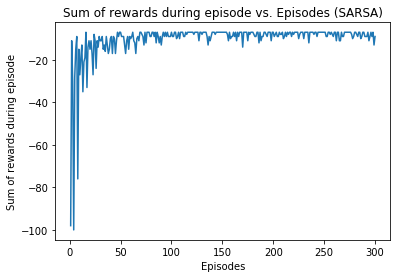

In [5]:
def epsilon_greedy(epsilon,Q,s,world): #Epsilon greedy implementation
    if np.random.random_sample() < epsilon: #If a random sample (from uniform distribution between 0 and 1) is less than epsilon we choose a random action
        return np.random.choice(world.actions)
    else:
        return np.argmax(Q[s, :]) #Otherwise we return the best action (that maximises Q)
    
def optimal_solution(Q,world):  # We find the best solution
    s = world.start  #We start at the starting state
    states = [world.start]
    rewards = 0
    while s!=world.goal: #We have finished the optimal solution when we reach the goal 
        if rewards< world.penalty*len(world.states):   #It is not possible for us to find a path longer than visiting all of the states, so an optimal path is not possible if this condition is met
            print('No solution found.')
            return states
        sv,rv,pv = world.state_transition(s) 
        best_action = np.argmax(Q[s,:])  #We find and take the best action from a state in the solution until we reach the goal
        rewards += rv[best_action]
        s = sv[best_action]
        states.append(s)
    return states  # We return the list of states in the optimal solution

def SARSA(episodes,alpha,epsilon_in,world,plotting='off',printing='off'): #Implementing SARSA
    Q = np.zeros((len(world.states),len(world.actions)))  #Initialising Q = zero matrix
    sum_of_rewards=[]
    episode_list=[]
    for episode in range(episodes):
        s=world.start
        step=1
        rewards = 0
        if epsilon_in !='1/t':  #Added functionality of variable epsilon over timesteps
            epsilon = epsilon_in
        else:
            epsilon = 1/step
        a = epsilon_greedy(epsilon,Q,s,world)
        while s != world.goal:
            if epsilon_in =='1/t':
                epsilon = 1/step
            sv,rv,pv = world.state_transition(s)
            a_next = epsilon_greedy(epsilon, Q, sv[a],world)
            rewards += rv[a]
            Q[s,a] += alpha*(rv[a] + world.gamma*Q[sv[a],a_next]-Q[s,a])
            s = sv[a]
            a = a_next
            step+=1
        episode_list.append(episode+1)
        sum_of_rewards.append(rewards)
    
    if plotting=='on': #Plotting
        plt.figure()
        plt.plot(episode_list, sum_of_rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Sum of rewards during episode')
        plt.title('Sum of rewards during episode vs. Episodes (SARSA)')
    
    if printing=='on': #Printing
        states = optimal_solution(Q,world)
        print(world.print_solution(states))


#We run an example on the 'world' gridworld with epsilon = 0.1
SARSA(300,0.4,0.1,world,plotting='on',printing='on')

Here we see that the SARSA algorithm is successful in finding an optimal path for this world. 

We also observe that sum of the rewards (and hence the performance) in the SARSA algorithm with an $\varepsilon$-greedy policy (with $\varepsilon = 0.1$ and $\alpha = 0.4$) increases as the number of episodes increases. This occurs up until a certain amount of episodes, after which there is little to no improvement. There is some randomness and variability in the sum of rewards of episodes, as the policy is $\varepsilon$-greedy, so this means there is an $\varepsilon$ chance of not moving in the best direction. Hence, if we get unlucky and move in the wrong direction many times in an episode, we will observe a drop in the total rewards for that episode.

c. Finally, show the solution your algorithm has reached for different values of $\varepsilon$.
<div style="text-align: right"><b>[10 marks]</b></div>

ε = 0
Solution:
+-+-+-+-+-+
|S|*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

ε = 0.05
Solution:
+-+-+-+-+-+
|S|*|*|*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

ε = 0.1
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*|*|*|*|G|
+-+-+-+-+-+

ε = 0.5
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*|*|*|*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*|G|
+-+-+-+-+-+

ε = 1
Solution:
+-+-+-+-+-+
|S|*| | | |
+-+-+-+-+-+
| |*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



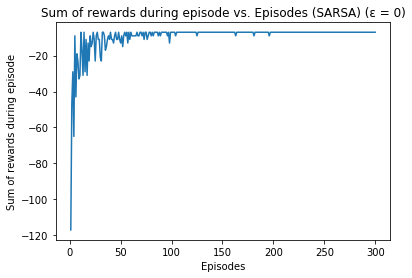

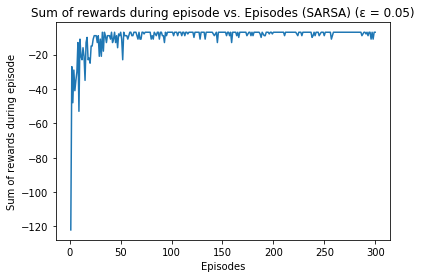

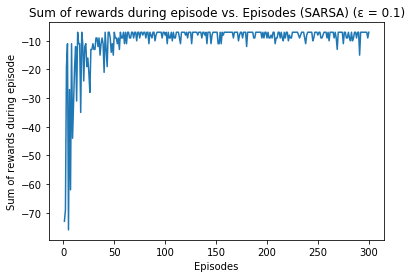

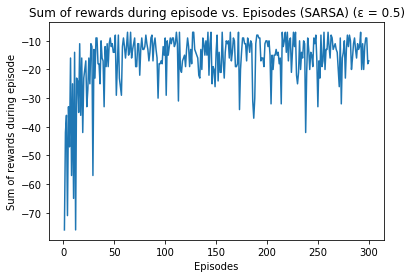

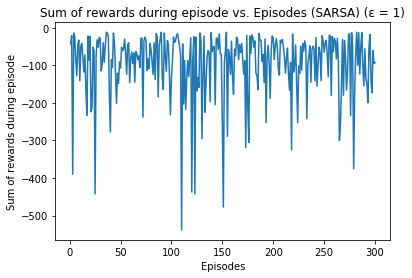

In [6]:
epsilons=[0, 0.05, 0.1, 0.5, 1] 

#Varying epsilon and showing the solution and sum of rewards graphs

for epsilon in epsilons:
    print('\u03b5 = '+str(epsilon))
    SARSA(300,0.4,epsilon,world,plotting='on',printing='on')
    plt.title('Sum of rewards during episode vs. Episodes (SARSA) (\u03b5 = '+str(epsilon)+')')

We observe the solution the SARSA algorithm has reached for different values of $\varepsilon$. With a completely random policy ($\varepsilon = 1$) we observe that the performance (sum of rewards) is random over all episodes. This is because the actions taken are completely random. Hence, it is not guaranteed that we converge to an optimal path for high values of $\varepsilon$. In some runs, solutions converge to an optimal path for all values of $\varepsilon$ (as this world is quite simple), but these optimal paths may differ as there are several paths that all have the same minimal reward value. 

We observe that there is less variability for smaller $\varepsilon$s, as the actions taken are more likely to be the best actions.

## 3. Q-learning 
SARSA is called an "on-policy" algorithm, because it makes assumptions on what the action that the policy will make at the next step to estimate $Q$. Therefore, the value function is dependent on the policy! 
$Q$-learning takes an alternative view, so-called "off-policy", where the value of a state-action pair is independent on the policy's actions, and is instead dependent on <i>the best possible course of action thereafter</i>. This is achieved by amending the update function: 
    $$
	Q^{(t+1)}(S_t,A_t)\leftarrow Q^{(t)}(S_t,A_t)+\alpha\left[
	R_{t+1} + \gamma \max_a Q^{(t)}(S_{t+1},a)-Q(S_t,A_t)
	\right]
	$$
    
In this part, you will:

a. Implement the off-policy Q-learning algorithm and use it to solve the problem. 
<div style="text-align: right"><b>[10 marks]</b></div>
b. Produce a graph showing the performance of the agent in y-axis and the number of episodes in x-axis. 
<div style="text-align: right"><b>[10 marks]</b></div>

Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*| | | | |
+-+-+-+-+-+
|*|*|*|*|G|
+-+-+-+-+-+



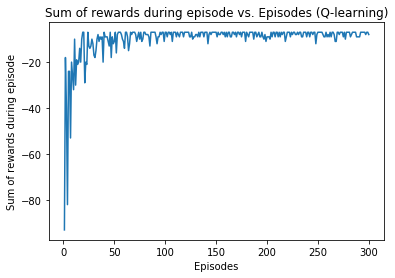

In [7]:
def Q_learning(episodes,alpha,epsilon,world,plotting='off',printing='off'): #Implementing the Q-learning algorithm
    Q = np.zeros((len(world.states),len(world.actions))) #Initialising Q = zero matrix
    sum_of_rewards = []
    episode_list = []
    for episode in range(episodes):
        s = world.start
        step = 0
        rewards = 0
        while s != world.goal:
            sv,rv,pv = world.state_transition(s)
            a = epsilon_greedy(epsilon,Q,s,world)
            rewards += rv[a]
            Q[s,a] += alpha*(rv[a] + world.gamma*max(Q[sv[a],:])-Q[s,a])
            s = sv[a]
            step += 1
        episode_list.append(episode+1)
        sum_of_rewards.append(rewards)
    if plotting == 'on':  #Plotting
        plt.figure()
        plt.plot(episode_list, sum_of_rewards)
        plt.xlabel('Episodes')
        plt.ylabel('Sum of rewards during episode')
        plt.title('Sum of rewards during episode vs. Episodes (Q-learning)')
    
    if printing == 'on':  #Printing
        states = optimal_solution(Q,world)
        print(world.print_solution(states))

#We run an example on the 'world' gridworld with epsilon = 0.1        
Q_learning(300,0.4,0.1,world,plotting='on',printing='on')

Here we see that the Q-learning algorithm is successful in finding an optimal path for this world. 

In addition, we observe that sum of the rewards (and hence the performance) in the Q-learning algorithm with an $\varepsilon$-greedy policy (with $\varepsilon = 0.1$ and learning rate $\alpha = 0.4$) increases as the number of episodes increases. This occurs up until a certain amount of episodes, after which there is little to no improvement. There is some randomness and variability in the sum of rewards of episodes, as the policy is $\varepsilon$-greedy, so this means there is an $\varepsilon$ chance of not moving in the best direction. Hence, if we get unlucky and move in the wrong direction many times in an episode, we will observe a drop in the total rewards for that episode.

c. Finally, show the solution your algorithm has reached for different values of $\varepsilon$.
<div style="text-align: right"><b>[10 marks]</b></div>

ε = 0
Solution:
+-+-+-+-+-+
|S| | | | |
+-+-+-+-+-+
|*|*| | | |
+-+-+-+-+-+
| |*| | | |
+-+-+-+-+-+
| |*|*| | |
+-+-+-+-+-+
| | |*|*|G|
+-+-+-+-+-+

ε = 0.05
Solution:
+-+-+-+-+-+
|S|*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

ε = 0.1
Solution:
+-+-+-+-+-+
|S|*| | | |
+-+-+-+-+-+
| |*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

ε = 0.5
Solution:
+-+-+-+-+-+
|S|*|*|*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*| |
+-+-+-+-+-+
| | | |*|*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+

ε = 1
Solution:
+-+-+-+-+-+
|S|*|*|*|*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |*|
+-+-+-+-+-+
| | | | |G|
+-+-+-+-+-+



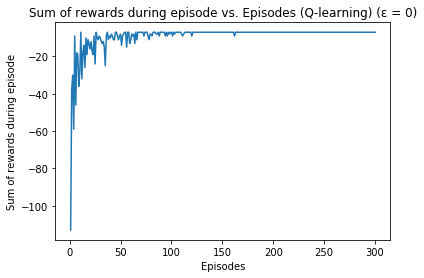

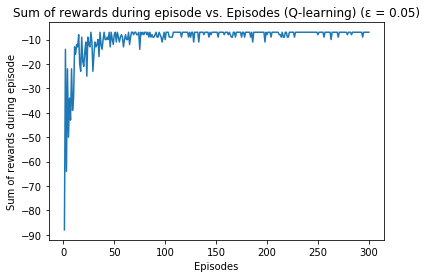

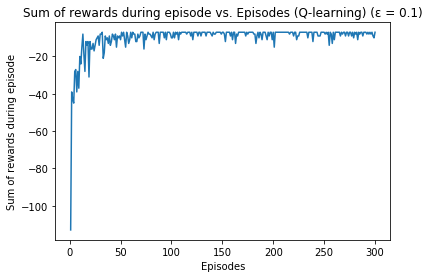

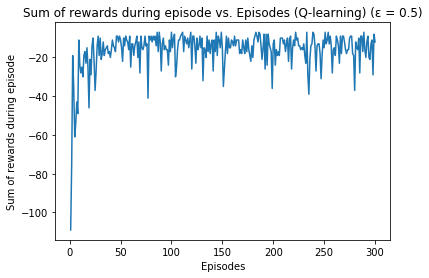

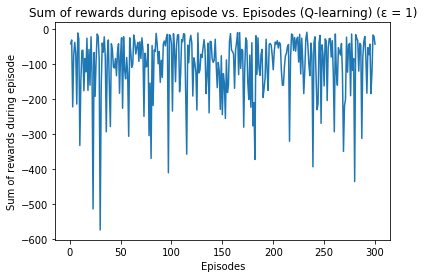

In [8]:
epsilons=[0, 0.05, 0.1, 0.5, 1]

#Varying epsilon and showing the solution and sum of rewards graphs

for epsilon in epsilons:
    print('\u03b5 = '+str(epsilon))
    Q_learning(300,0.4,epsilon,world,plotting='on',printing='on')
    plt.title('Sum of rewards during episode vs. Episodes (Q-learning) (\u03b5 = '+str(epsilon)+')')

We observe the solution the Q-learning algorithm has reached for different values of $\varepsilon$. Similarly to the SARSA algorithm, with a completely random policy ($\varepsilon = 1$) we observe that the performance (sum of rewards) is random over all episodes. This is because the actions taken are completely random. Hence, it is not guaranteed that we converge to an optimal path for high values of $\varepsilon$. Solutions converge to an optimal path for all values of $\varepsilon$ (as this world is quite simple), but these optimal paths may differ as there are several paths that all have the same minimal reward value. 

Again, as with the SARSA algorithm, we observe that there is less variability for smaller $\varepsilon$s, as the actions taken are more likely to be the best actions.

Finally, compare the two algorithms on a number of gridworld configurations (see examples below, but generate a few of your own) and discuss the results. 
<div style="text-align: right"><b>[10 marks]</b></div>

World 1:
Grid world:
+-+-+-+-+-+-+-+-+-+-+
|S| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | |X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+

SARSA
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*| | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*|*| | |
+-+-+-+-+-+-+-+-+-+-+
|X|X|X|X|X|X| |*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | |*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | |*|*|*|*| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |*| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |*| |X|X|X|X|X|X|
+-+-+-+-+-+-+-+-+-+-+
| | |*|*|*|*| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | |*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |*|*|G|
+-+-+-+-+-+-+-+-+-+-+

Q-learning
Solution:
+-+-+-+-+-+-+-+-

Text(0.5, 1.0, 'World 4: Sum of rewards during episode vs. Episodes (Q-learning)')

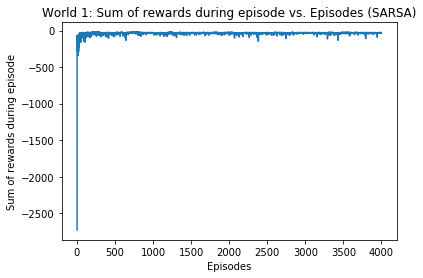

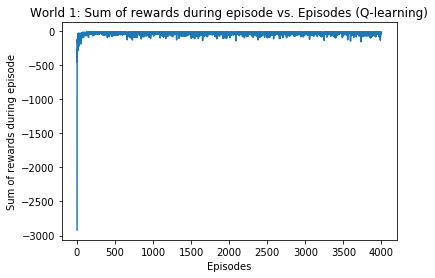

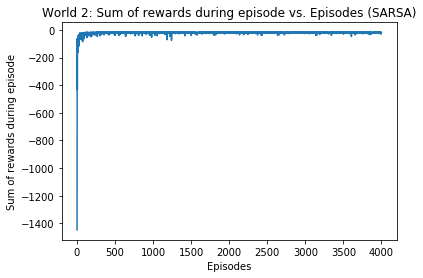

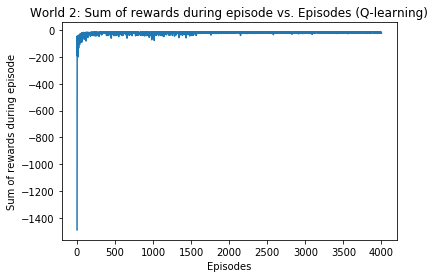

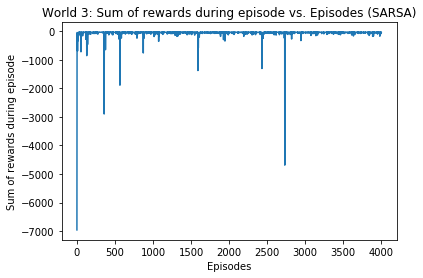

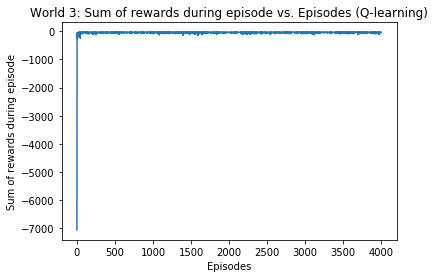

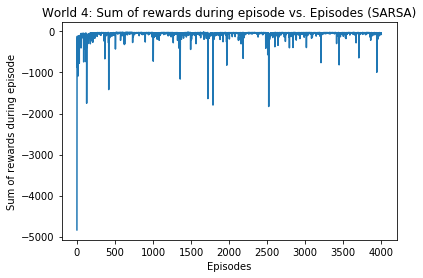

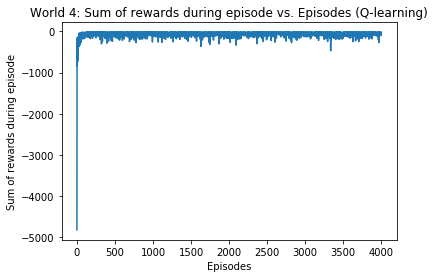

In [9]:
#Defining world 1 and testing our algorithms 

world1 = GridWorld(10,10, gamma=0.9999, start=[0,0], goal=[9,9], cliff=[[0,2], [1,2], [2,2], [3,2], [4,2], [5,2], 
                                                                     [4,6], [5,6], [6,6], [7,6], [8,6], [9,6]])

print('World 1:')
print(world1.tostring())

print('SARSA')
SARSA(4000,0.4,0.1,world1,plotting='on',printing='on')
plt.title('World 1: Sum of rewards during episode vs. Episodes (SARSA)')

print('Q-learning')
Q_learning(4000,0.4,0.1,world1,plotting='on',printing='on')
plt.title('World 1: Sum of rewards during episode vs. Episodes (Q-learning)')


#Defining world 2 and testing our algorithms 

cliff = [ [i,j] for i in range(3,7) for j in range(3,7) ]
       
world2 = GridWorld(10,10, gamma=0.9999, start=[9,0], goal=[0,9], cliff=cliff)
print('World 2:')
print(world2.tostring())

print('SARSA')
SARSA(4000,0.4,0.1,world2,plotting='on',printing='on')
plt.title('World 2: Sum of rewards during episode vs. Episodes (SARSA)')

print('Q-learning')
Q_learning(4000,0.4,0.1,world2,plotting='on',printing='on')
plt.title('World 2: Sum of rewards during episode vs. Episodes (Q-learning)')


#Defining world 3 and testing our algorithms 

world3 = GridWorld(10,10, gamma=0.9999, start=[0,0], goal=[9,9], cliff=[[0,1], [1,1], [2,1], [3,1], [4,1], [5,1],[6,1],[7,1],[8,1],
                                                                     [1,3], [2,3], [3,3], [4,3], [5,3], [6,3],[7,3],[8,3],[9,3],
                                                                     [1,4], [0,6], [3,6], [1,9], [3,8], [3,9],[3,7],[2,6],[1,8],
                                                                     [3,5], [8,8], [9,8], [7,8], [4,8], [5,8],[5,7],[5,6],[7,7],
                                                                     [5,4], [7,6], [7,5]])                                                                   
print('World 3:')
print(world3.tostring())

print('SARSA')
SARSA(4000,0.4,0.01,world3,plotting='on',printing='on')
plt.title('World 3: Sum of rewards during episode vs. Episodes (SARSA)')

print('Q-learning')
Q_learning(4000,0.4,0.01,world3,plotting='on',printing='on')
plt.title('World 3: Sum of rewards during episode vs. Episodes (Q-learning)')


#Defining world 4 and testing our algorithms 

world4 = GridWorld(10,20, gamma=0.99999, start=[0,0], goal=[0,19], cliff=[[0,1], [2,1], 
                                                                      [0,3], [2,3],
                                                                      [0,2], [2,2],
                                                                      [0,4], [2,4],
                                                                      [0,5], [2,5],
                                                                      [0,6], [2,6],
                                                                      [0,7], [2,7],
                                                                      [0,8], [2,8],
                                                                      [0,9], [2,9],
                                                                      [0,10], [2,10],
                                                                      [0,11], [2,11],
                                                                      [0,12], [2,12],
                                                                      [0,13], [2,13],
                                                                      [0,14], [2,14],
                                                                      [0,15], [2,15],
                                                                      [0,16], [2,16],
                                                                      [0,17], [2,17],
                                                                      [0,18], [2,18]])
print('World 4:')
print(world4.tostring())

print('SARSA')
SARSA(4000,0.4,0.1,world4,plotting='on',printing='on')
plt.title('World 4: Sum of rewards during episode vs. Episodes (SARSA)')
    
print('Q-learning')
Q_learning(4000,0.4,0.1,world4,plotting='on',printing='on')
plt.title('World 4: Sum of rewards during episode vs. Episodes (Q-learning)')




If we select a $\gamma$ parameter which is too small, then the SARSA algorithm is more likely get 'stuck' at certain states. This can happen if $|Q(s,a)|$ gets too large comparative to the reward for a 'bad' action, e.g. if moving costs -1 and $\gamma = 0.9$ and Q values reach -10, then moving into a wall (at the edge of a world) and remaining in the same place can provide a positive effect on $Q(s,a)$, so this value will remain around -10 and remain the best choice. Hence we choose a value of $\gamma$ very close to 1 for worlds in which $|Q(s,a)|$ gets large quickly, as otherwise it is less likely that the SARSA algorithm finds a solution. 

It is still possible for SARSA to get stuck- this is more common with very difficult worlds (with lots of possible negative rewards) or with high $\varepsilon$s (higher chance of negative rewards from walking off a cliff). Occasionally, for the worlds above, the SARSA algorithm will struggle to find a solution due to these reasons. 

The algorithm getting stuck causes the 'spikes' that sometimes appear in the sum of rewards graphs. These spikes are smaller for Q-learning than for SARSA, as Q-learning gets stuck less. 

In the solutions for World 1 and World 4, we observe the differences between SARSA and Q-learning algorithms. It is clear that SARSA takes a much safer route, at the expense of taking a longer route. Whereas the Q-learning algorithm takes the shortest possible route, but this is very risky as there is an $\varepsilon$ chance of walking in a random direction, which could be off the cliff. This happens because Q-learning approximates considers the maximum Q over all possible actions (Q-learning attempts to find the optimal path irrespective of the policy), whilst SARSA considers the implications of the $\varepsilon$ chance of taking a random action (SARSA optimises the agent's actions to maximise the reward, taking into account the policy). As a result of this Q-learning tends to achieve a lower (worse) sum of rewards during an episode (but a shorter route), as we can see by the solutions found.

In World 2 there is usually little difference between the two algorithms. Usually the SARSA algorithm avoids moving within 1 step of the central block of cliffs, whereas the Q-learning algorithm sometimes moves within 1 step of the cliffs.

In World 3, we show that Q-learning and SARSA algorithms are both able to solve a relatively complex maze, when $\varepsilon$ is small (0.01). If $\varepsilon$ were to be larger, it would be very difficult for the algorithms to find a solution, as there are very few paths to the solution, all of which are surrounded by cliffs.

As the goals of SARSA and Q-learning algorithms are different, the best algorithm depends on whether you require the shortest path regardless of policy or a maximal reward. In the former case a Q-learning algorithm is suitable, but in the latter case a SARSA algorithm is superior.